## **Predicting House Prices in Melbourne, USA**


This notebook aims to analyze the Melbourne House Price dataset and build a linear regression model to predict house prices.

*The general structure is as follows:*

1. Data loading and cleaning
2. Exploratory Data Analysis (EDA)
3. Modelling

In [89]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [91]:
df = pd.read_csv("D:/Studies/Predictive models/Melbourne_housing_FULL.csv")
df.shape

(34857, 21)

In [93]:
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

After reviewing the column descriptions on Kaggle, I've selected the columns that won't be used in this analysis, so they can be removed.

In [96]:
remove_columns = [
    "Suburb",
    "Address",
    "Postcode",
    "Method",
    "SellerG",
    "CouncilArea",
    "Lattitude",
    "Longtitude",
]

In [98]:
df = df.drop(columns=remove_columns)

Let’s take a look at a sample of the data and see if anything stands out or looks unusual.

In [101]:
df.sample(10)

,Rooms,Type,Price,Date,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Regionname,Propertycount
7163,2,t,590000.0,2016-11-12,11.2,NaN,NaN,NaN,NaN,NaN,NaN,Western Metropolitan,2291.0
2658,4,h,2950000.0,2016-05-07,7.8,4.0,2.0,4.0,661.0,NaN,NaN,Southern Metropolitan,8920.0
24948,4,h,733000.0,2017-10-21,14.8,NaN,NaN,NaN,NaN,NaN,NaN,Western Metropolitan,2674.0
7443,1,u,340000.0,2016-08-28,5.5,1.0,1.0,1.0,0.0,NaN,NaN,Northern Metropolitan,11364.0
34787,3,t,1400000.0,2018-02-24,7.0,3.0,2.0,2.0,219.0,180.00,2016.0,Northern Metropolitan,8870.0
17504,2,t,480000.0,2017-07-08,23.0,2.0,1.0,1.0,2040.0,NaN,NaN,Eastern Metropolitan,11925.0
11688,3,u,900000.0,2016-08-06,11.8,3.0,1.0,1.0,265.0,91.00,1990.0,Southern Metropolitan,3578.0
30798,2,u,460000.0,2017-12-09,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Southern Metropolitan,13240.0
12339,3,h,3025000.0,2017-04-22,11.2,3.0,2.0,4.0,649.0,195.00,1967.0,Southern Metropolitan,10579.0
13679,3,h,NaN,2017-05-13,3.3,3.0,2.0,1.0,278.0,162.52,1890.0,Southern Metropolitan,14887.0


The first thing that pops out is the NaN values in the Price column. The ultimate goal of this analysis is to predict the house price. We have no use for rows with NaNs in our dependent variable.

In [104]:
df = df.dropna(subset=["Price"])
df.shape

(27247, 13)

Another noticeable issue from the sample data is the high number of NaNs in several columns. Let’s dig into that and investigate further.

In [107]:
df.isna().mean()

Rooms            0.000000
Type             0.000000
Price            0.000000
Date             0.000000
Distance         0.000037
Bedroom2         0.236393
Bathroom         0.236613
Car              0.250450
Landsize         0.340037
BuildingArea     0.608911
YearBuilt        0.556502
Regionname       0.000110
Propertycount    0.000110
dtype: float64

The BuildingArea and YearBuilt columns have more than 50% missing values, making them essentially unusable. Dropping rows with null values in these columns would result in losing half of the dataset, and imputing them later could introduce significant bias.

There are also other columns with missing data, but those will be explored more thoroughly during the EDA and modeling phases. Ultimately, how we handle missing data will depend on the modeling decisions we make later on.

In [110]:
df = df.drop(columns=["BuildingArea", "YearBuilt"])

Lets inspect the dataset to see if there are any more issues.

In [113]:
df.describe().round(2)

,Rooms,Price,Date,Distance,Bedroom2,Bathroom,Car,Landsize,Propertycount
count,27247.00,27247.00,27247,27246.00,20806.00,20800.00,20423.00,17982.00,27244.00
mean,2.99,1050173.34,2017-05-23 15:05:38.106947584,11.28,3.05,1.59,1.72,593.49,7566.78
min,1.00,85000.00,2016-01-28 00:00:00,0.00,0.00,0.00,0.00,0.00,83.00
25%,2.00,635000.00,2016-11-19 00:00:00,6.40,2.00,1.00,1.00,219.00,4294.00
50%,3.00,870000.00,2017-07-08 00:00:00,10.50,3.00,1.00,2.00,512.00,6567.00
75%,4.00,1295000.00,2017-10-28 00:00:00,14.00,4.00,2.00,2.00,664.00,10412.00
max,16.00,11200000.00,2018-03-17 00:00:00,48.10,20.00,9.00,18.00,433014.00,21650.00
std,0.95,641467.13,NaN,6.79,0.96,0.70,0.99,3757.27,4492.38


It appears that the Distance, Bedroom2, Bathroom, Car, and Landsize columns have two issues:

The minimum value for these columns is 0, which requires investigation because no home should have 0 bathrooms, for example.

Let’s take a closer look at those 0 values.

In [116]:
df.apply(lambda x: x == 0).mean()

Rooms            0.000000
Type             0.000000
Price            0.000000
Date             0.000000
Distance         0.002129
Bedroom2         0.000587
Bathroom         0.001248
Car              0.045913
Landsize         0.071274
Regionname       0.000000
Propertycount    0.000000
dtype: float64

Indeed, these variables contain a significant number of 0s. It doesn’t make sense for Bedroom2 and Bathroom to have 0s, so I will treat those as anomalies or data entry mistakes and exclude them.

For the other variables, the dataset documentation didn’t provide clear explanations for the 0s, so I will keep them as is but make the following assumptions, though I’m unsure of their accuracy:

* Car: I’ll assume that a value of 0 indicates the house has no car parking spots. This seems like a reasonable assumption.
* Landsize: This is a bit unclear, but I’ll assume that a value of 0 means the house is a flat or apartment without any land or garden.
* Distance: The distance variable represents the distance of the house from the city center. Since it’s not clear whether the center refers to a specific point or a district, I’ll assume that a value of 0 means the house is located in the city center.

In [119]:
df = df[(df["Bedroom2"] != 0) & (df["Bathroom"] != 0)]
df.shape

(27203, 11)

Now let's inspect the categorical variables.

In [122]:
df["Type"].value_counts()

Type
h    18450
u     5891
t     2862
Name: count, dtype: int64

In [124]:
df["Regionname"].value_counts()

Regionname
Southern Metropolitan         8499
Northern Metropolitan         7853
Western Metropolitan          5810
Eastern Metropolitan          3269
South-Eastern Metropolitan    1341
Eastern Victoria               166
Northern Victoria              166
Western Victoria                96
Name: count, dtype: int64

The categorical variables seem to be in good shape, with no missing data or other issues. However, the "h," "u," and "t" codes in the Type variable are a bit cryptic. Let's transform them into more understandable labels.

In [127]:
df["Type"] = df["Type"].map({"h": "house", "u": "unit", "t": "townhouse"})

That concludes the data loading and cleaning step. We have a dataframe with around 27 thousand rows.

## *Exploratory Data Analysis*

Let’s start by examining the dependent variable in this analysis: Price. We’ll look at its distribution, any potential outliers, and other relevant characteristics.

<Axes: xlabel='Price', ylabel='Count'>

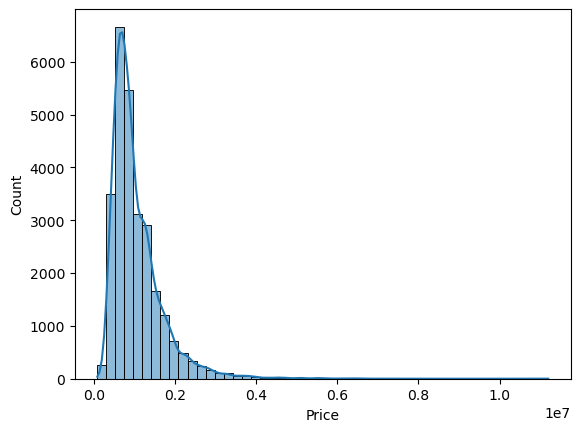

In [132]:
sns.histplot(df.Price, bins=50, kde=True)

The house price variable exhibits a heavy right skew. To make it easier to interpret and work with, I’ll take the logarithm of this variable. This will help normalize the distribution and reduce the impact of extreme values.

In [135]:
df["price_log"] = np.log(df["Price"])

Let’s investigate which variables are most strongly correlated with Price. For categorical and count variables, I’ll use boxplots to visualize the relationship. For continuous variables, I’ll use scatterplots to assess the correlation more clearly.

<Axes: xlabel='Car', ylabel='price_log'>

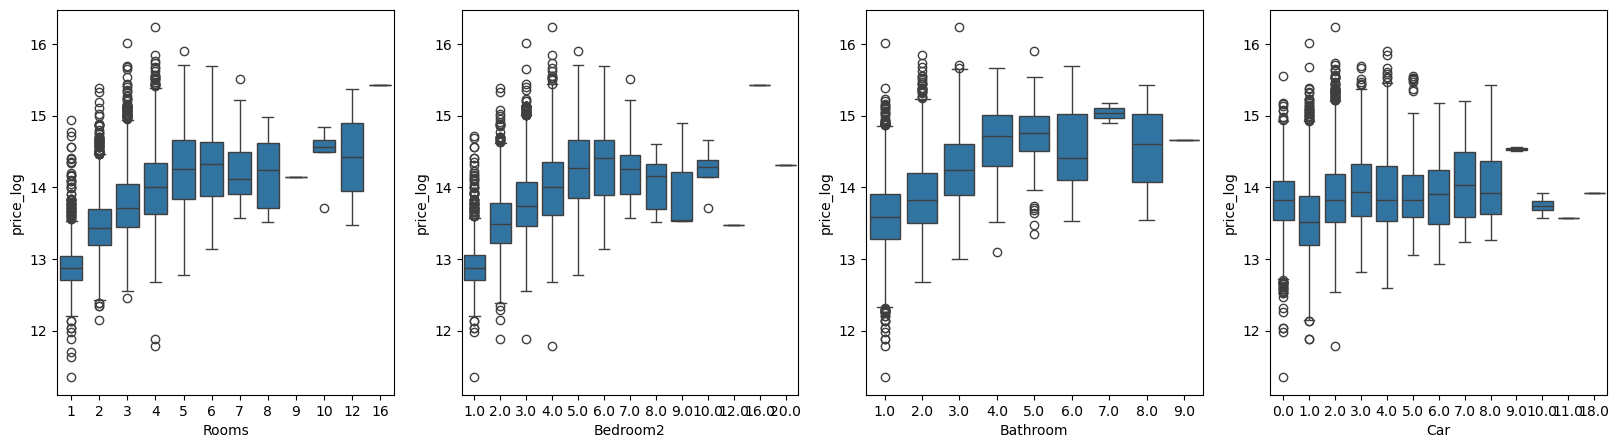

In [138]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(x="Rooms", y="price_log", data=df, ax=axs[0])
sns.boxplot(x="Bedroom2", y="price_log", data=df, ax=axs[1])
sns.boxplot(x="Bathroom", y="price_log", data=df, ax=axs[2])
sns.boxplot(x="Car", y="price_log", data=df, ax=axs[3])

This is quite interesting! It looks like the effect of the number of rooms, bedrooms, and bathrooms on the price increases and then plateaus around 5. On average, a 5-room house costs as much as an 8-bedroom house. Interestingly, the number of car parking spots doesn’t appear to have any correlation with the price.

I also suspect that the Rooms variable might be strongly correlated with the combination of Bedroom2 and Bathroom. Let's take a closer look at that and investigate further.

In [141]:
df["bathrooms_bedrooms"] = df["Bathroom"] + df["Bedroom2"]

In [143]:
df[["Rooms", "bathrooms_bedrooms"]].corr()

,Rooms,bathrooms_bedrooms
Rooms,1.000000,0.904111
bathrooms_bedrooms,0.904111,1.000000


The correlation is indeed very strong. Including all of these variables could lead to multicollinearity. While multicollinearity isn’t a huge problem for predictive modeling, it can make the model harder to interpret. Personally, when looking for a home, I care more about the total number of rooms rather than the number of bathrooms. Since Bathroom and Bedroom2 have a lot of missing values, and Bathroom + Bedroom2 is roughly equal to Rooms, we can drop both Bathroom and Bedroom2 without losing much information.

In [146]:
df = df.drop(columns=["Bedroom2", "Bathroom"])

Let's take a look at Type and Regionname variables.



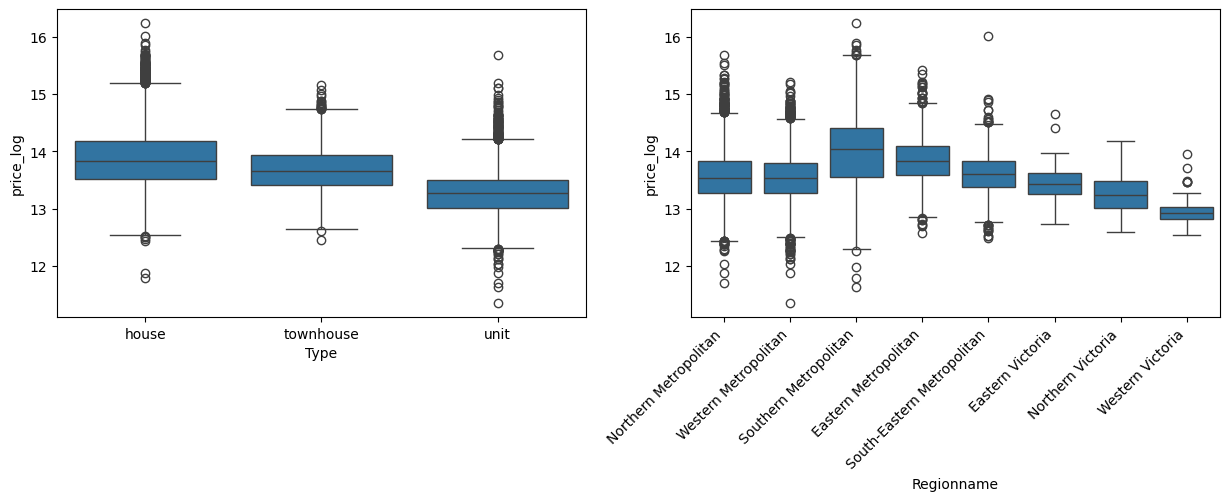

In [149]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.boxplot(x="Type", y="price_log", data=df, ax=axs[0])
sns.boxplot(x="Regionname", y="price_log", data=df, ax=axs[1])
plt.xticks(rotation=45, ha="right");

Both of these variables show a correlation with Price. Houses and townhouses tend to be more expensive, while the Southern Metropolitan region appears to have higher-priced homes, although the prices are more spread out.

Now, let’s take a look at the continuous variables.

<Axes: xlabel='Propertycount', ylabel='price_log'>

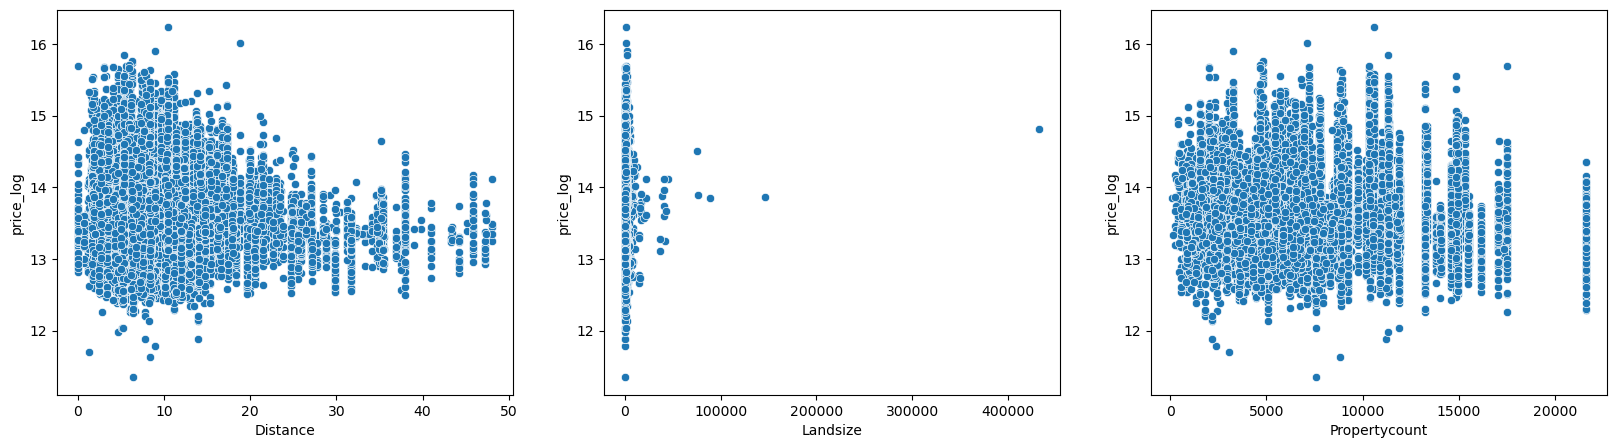

In [152]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
sns.scatterplot(x='Distance', y='price_log', data=df, ax=axs[0])
sns.scatterplot(x='Landsize', y='price_log', data=df, ax=axs[1])
sns.scatterplot(x='Propertycount', y='price_log', data=df, ax=axs[2])

It’s immediately clear that the Landsize variable has some significant outliers. These outliers could complicate our modeling, as the algorithm I plan to use, ordinary least squares, can be heavily influenced by outliers, which is often undesirable.

The good news is that I’m not interested in properties with such large amounts of land. Anything above 10,000 square meters is too much land for me to manage, so I’ll exclude homes with a Landsize greater than 10,000 square meters.

This decision will reduce the population of homes to which my model will generalize, but that’s perfectly fine as long as I make this decision consciously and keep it in mind when interpreting the model later on.

In [155]:
df = df[df["Landsize"] < 10000]
df.shape

(17902, 11)

<Axes: xlabel='Landsize', ylabel='Count'>

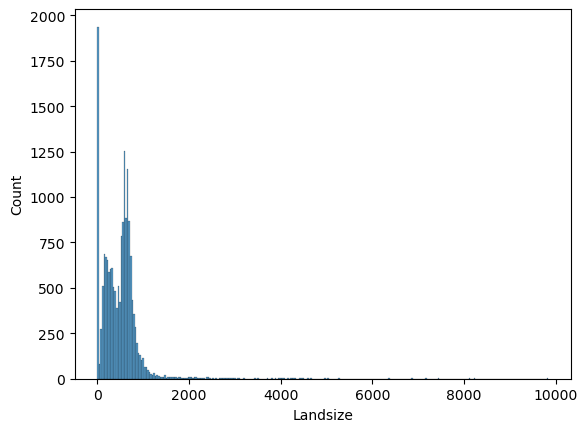

In [157]:
sns.histplot(x='Landsize', data=df)

The Landsize variable is still heavily skewed, so I’ll apply a log transformation to it. Since taking the log of 0 is undefined, I’ll add 1 to the variable before transforming it. This is essentially assuming that even homes (or flats) with no land have at least 1 square meter of land.

In [160]:
df["log_landsize"] = np.log(df["Landsize"] + 1)

Let's take a look on the Date variable.



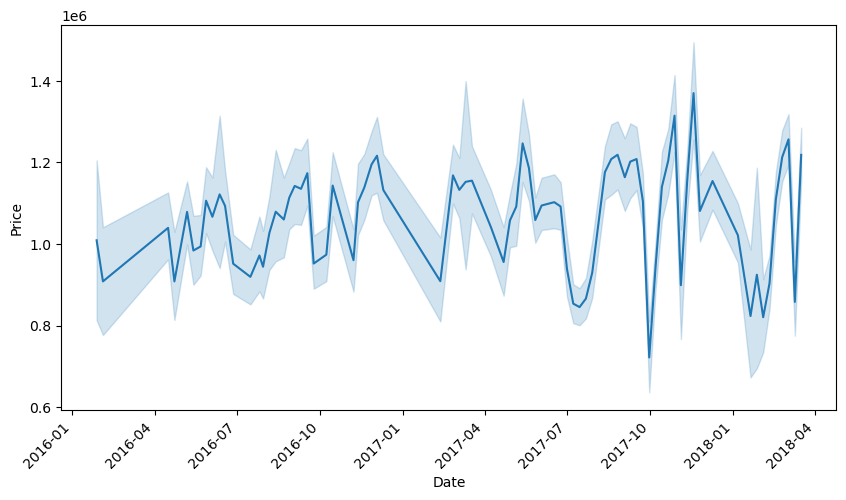

In [163]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(x='Date', y='Price', data=df)
plt.xticks(rotation=45, ha="right");

It goes down about end of Autumn-Winter, but the overall trend hard to interpret. Let's see if there is a monthly pattern.

In [166]:
df["month"] = df["Date"].dt.month

<Axes: xlabel='month', ylabel='price_log'>

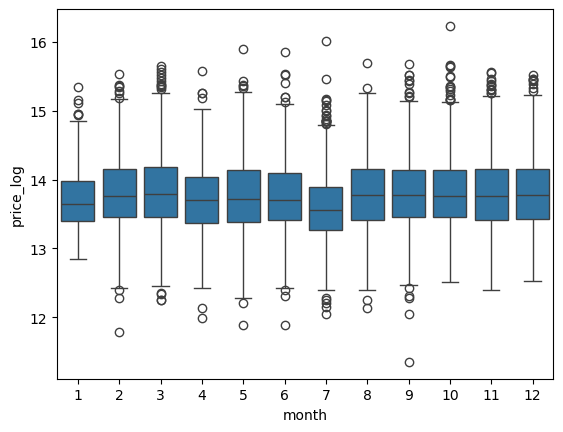

In [168]:
sns.boxplot(x='month', y='price_log', data=df)

There is a visible dip in house prices at around January and July. However, this could just be a random dip.

This concludes the EDA! During the EDA above, I have made the following decisions before my modelling step:

Log-transform the dependent variable, Price.
Remove Bedroom2 and Bathroom variables.
Remove rows where Landsize is above 10000 and log-transform the Landsize variable.

## Modelling

Time to fit that linear regression model! First I need to define the variables I will use in the model.

In [173]:
categorical_feats = ["Type", "Regionname", "month"]
numerical_feats = ["Rooms", "Distance", "log_landsize", "Propertycount", "Car"]

y = df["price_log"]
X = df[categorical_feats + numerical_feats]

Then I need to split my data into a train set and a test set. I will use the test set at the very end of the notebook to report the accuracy of my model.

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Now lets encode the categorical variables so that we can feed them the model.

In [179]:
encoder = OneHotEncoder(
    drop="first",
    # Hardcoded categories to avoid errors when the test set has missing categories
    categories=[
        ["house", "unit", "townhouse"],
        [
            "Northern Metropolitan",
            "Western Metropolitan",
            "Southern Metropolitan",
            "Eastern Metropolitan",
            "South-Eastern Metropolitan",
            "Eastern Victoria",
            "Northern Victoria",
            "Western Victoria",
        ],
        range(1, 13)
    ],
)

In [181]:
X_train_categorical_encoded = pd.DataFrame(
    encoder.fit_transform(X_train[categorical_feats]).toarray(),
    columns=encoder.get_feature_names_out(categorical_feats),
    index=X_train.index,
)

In [183]:
X_train_transformed = X_train.drop(columns=categorical_feats).join(X_train_categorical_encoded)

Lastly, we need to deal with missing values in the Car variable. I'll impute NaNs with the median.


In [186]:
imputer = SimpleImputer(strategy="median")
X_train_transformed["Car"] = imputer.fit_transform(X_train_transformed[["Car"]])

Finally it is time to fit a model!

In [189]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train_transformed, y_train)

LinearRegression()

In [191]:
# R-squared
model.score(X_train_transformed, y_train)

0.6901904620040697

R-squared of 69% is not bad! This means that our model accounts for more than two thirds of the varianve in our dependent variable, log(price).

However, we should really inspect the performance on training data. For that we need to pass the X_test dataset through the encoder and the imputer. It's key to only transform the data. Refitting on the test set would amount to "leaking" information, which would overstate the true performance of our model.

In [194]:
X_test_categorical_encoded = pd.DataFrame(
    # transform instead of fit_transform!
    encoder.transform(X_test[categorical_feats]).toarray(),
    columns=encoder.get_feature_names_out(categorical_feats),
    index=X_test.index,
)
X_test_transformed = X_test.drop(columns=categorical_feats).join(X_test_categorical_encoded)

# transform instead of fit_transform!
X_test_transformed["Car"] = imputer.transform(X_test_transformed[["Car"]])

In [196]:
# R-squared
model.score(X_test_transformed, y_test)

0.6787637520717016

That is quite close to the training set performance, which is a good sign!

Now let's interpret the coefficients.

In [199]:
# Coefficients
coefs = {feature: coef for feature, coef in zip(
    ["intercept"] + list(X_test_transformed.columns),
   [model.intercept_] + list(model.coef_),
)}
coefs

{'intercept': 13.342598913281458,
 'Rooms': 0.19234489503540636,
 'Distance': -0.04278415258517346,
 'log_landsize': 0.03640907961907866,
 'Propertycount': 1.19606878314003e-07,
 'Car': 0.030703363647100825,
 'Type_unit': -0.5053438833845165,
 'Type_townhouse': -0.17656016173110026,
 'Regionname_Western Metropolitan': -0.05628499883357657,
 'Regionname_Southern Metropolitan': 0.4545883762667819,
 'Regionname_Eastern Metropolitan': 0.28997678154799095,
 'Regionname_South-Eastern Metropolitan': 0.4928493661128955,
 'Regionname_Eastern Victoria': 0.627562553785734,
 'Regionname_Northern Victoria': 0.3449822111538962,
 'Regionname_Western Victoria': 0.013734148209229566,
 'month_2': -0.021889307553317063,
 'month_3': -0.00416801746400668,
 'month_4': -0.03471415399180536,
 'month_5': -0.03876847129060502,
 'month_6': -0.0392570921684144,
 'month_7': -0.07134015704559335,
 'month_8': -0.030015578714801646,
 'month_9': -0.024776960286706128,
 'month_10': -0.029743284569307086,
 'month_11': -

How do we interpret this? These coefficients essentially show how much we can expect the average value of log(price) to change with one-unit change in the dependent variable. For example, the coefficient near Distance variable says that, all else equal, being one kilometer further away from the centre equates to 0.043 lower log of house price. We can make this easier to interpret by transforming the coefficient.

In [202]:
np.exp(coefs["Distance"]) - 1


-0.04188182491958803

On average, being one kilometer further from the centre results in 4.2% lower house price. Lets try another variable.


In [205]:
np.exp(coefs["Regionname_Southern Metropolitan"]) - 1

0.575524726172306

Southern Metropolitan must be a rather fancy neighbourhood - all else equal, houses there are 57% more expensive than elsewhere!

Let's inspect several predictions.

In [208]:
y_pred = model.predict(X_test_transformed)
df_test = X_test.copy()
df_test["price_log_pred"] = y_test
df_test["price_pred"] = np.exp(y_pred)
df_test["price"] = np.exp(y_test)

In [210]:
df_test.sample(5)


,Type,Regionname,month,Rooms,Distance,log_landsize,Propertycount,Car,price_log_pred,price_pred,price
2833,house,Southern Metropolitan,10,4,9.0,6.670766,3265.0,3.0,15.285686,1.957431e+06,4350000.0
20527,house,Northern Metropolitan,9,2,3.4,5.017280,3593.0,1.0,14.018451,9.563252e+05,1225000.0
3672,house,Eastern Metropolitan,11,3,13.9,6.699500,9028.0,2.0,14.173185,1.082884e+06,1430000.0
15916,house,Northern Metropolitan,6,3,2.4,4.663439,14949.0,1.0,13.989464,1.178765e+06,1190000.0
12545,house,Northern Metropolitan,5,2,3.2,4.787492,3106.0,0.0,14.070153,9.146444e+05,1290000.0


Even though on the log scale the performance of the model seems good, comparing predicted and actual prices we see that the performance could be improved. Also, predicting house prices is hard!

Improvements
This is a quick analysis and a lot of improvements could be made to it.

Make train test split more realistic. By default, train_test_split splits the dataset randomly. However, our model is meant to forecast house prices in the real world, so a more realistic split would use the last half year of sales as in the test set.
Using cross-validation experiment with more advanced modelling techniques:
More variable transformations, e.g. Standard Scaling or adding polynomials.
Regularization and feature selection. Ridge regression and Lasso regression are simple extensions of the linear model that would allow us to control the complexity of the model.
Use Pipelines. Feeding data into the model to get a prediction is kind of messy and requires multiple steps. For both training and testing data we had to repeat essentially the same steps, which resulted in a lot of repetitive code. scikit-learn Pipelines should be used here.
Missing data imputation needs to be performed more carefully. Missing data in the Car column could itself be a predictor of price, in which case we should have added a binary variable indicating which rows were missing. This could be done using the add_indicator in SimpleImputer.
Use confidence intervals. A more actionable prediction would be not a point estimate, but instead an interval of reasonable house prices given input the input variables. Scikit-learn does not provide methods for computing confidence intervals, but statsmodels does.